In [ ]:
#1. Download the database from [https://drive.google.com/drive/folders/1ZVG-co0r0smof4aisFQiyo5eEoF8Zi-R?usp=sharing].
#2. Place the file in the same folder as this notebook.
#3. Run the cells below.

In [7]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

In [9]:
# Connect to DuckDB database file
con = duckdb.connect("gender_db.duckdb")


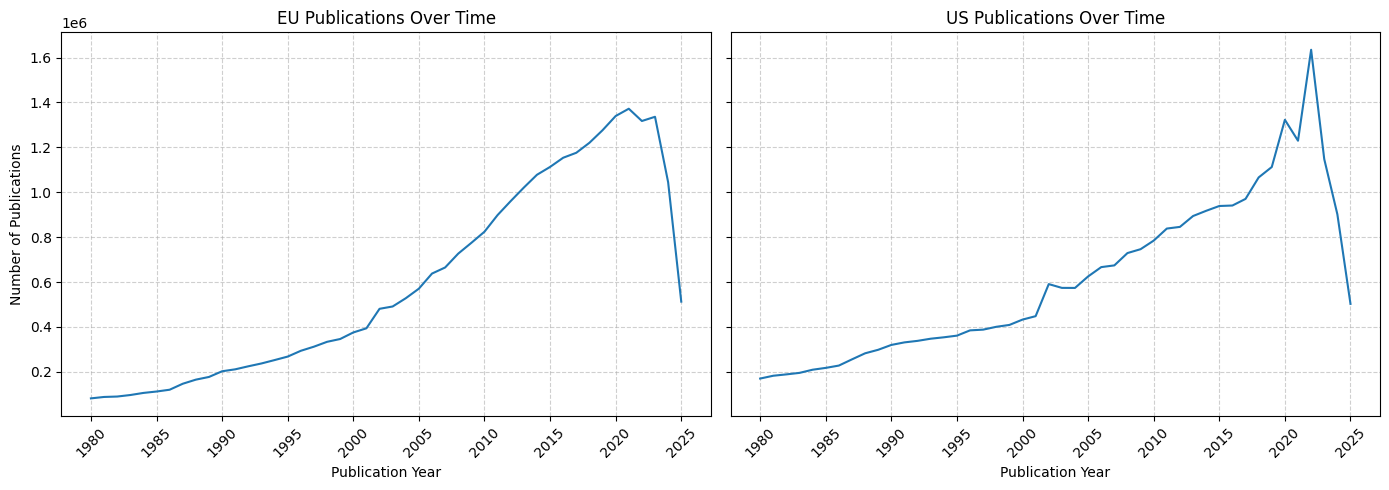

In [18]:
# Plotting total publications in USA vs EU

df_EU = con.query(""" 
    SELECT
        publication_year,
        COUNT(*) AS row_count
    FROM big_table_eu
    GROUP BY publication_year
    ORDER BY publication_year;
""").to_df() #Creating an EU df grouping by publication_year

df_US = con.query("""
    SELECT
        publication_year,
        COUNT(*) AS row_count
    FROM big_table_us
    GROUP BY publication_year
    ORDER BY publication_year;
""").to_df() #Creating an USA df grouping by publication_year

years_EU = df_EU["publication_year"].astype(int)
years_US = df_US["publication_year"].astype(int)
min_year = min(years_EU.min(), years_US.min())
max_year = max(years_EU.max(), years_US.max())
ticks = np.arange(min_year, max_year + 1, 5)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

#EU plot
axes[0].plot(df_EU["publication_year"], df_EU["row_count"])
axes[0].set_title("EU Publications Over Time")
axes[0].set_xlabel("Publication Year")
axes[0].set_ylabel("Number of Publications")
axes[0].set_xticks(ticks)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, linestyle="--", alpha=0.6)

#US plot 
axes[1].plot(df_US["publication_year"], df_US["row_count"])
axes[1].set_title("US Publications Over Time")
axes[1].set_xlabel("Publication Year")
axes[1].set_xticks(ticks)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
#Save as png
plt.savefig("total_publications.png", dpi=600, bbox_inches="tight")
plt.show()

In [19]:
# Creating working datasets

def add_shares(df, male_col, female_col, uk_col):
    total = df[male_col] + df[female_col] + df[uk_col]
    return df.assign(
        total=total,
        female_share=df[female_col] / total,
        male_share=df[male_col] / total,
        uk_share=df[uk_col] / total,
    )

fields  = ["health_sciences", "life_sciences", "physical_sciences", "social_sciences"] # for each reseach domain
regions = ["eu", "us"] # for eu and us
tables = {}


for field in fields:
    for region in regions:
        table_name = f"gender_year_{field}_{region}"

        df = con.query(f"SELECT * FROM {table_name}").to_df() #create df
        df = df[df["publication_year"] < 2021] #delete all years after 2020
        df = add_shares(df, "male", "female", "uk") #add shares, to not just have total amounts of male, female, unknown


        tables[table_name] = df
        globals()[table_name] = df


In [20]:
# adding presidential alignment to dataset
alignment_map = {
    # democratic
    1980: 1,
    1993: 1, 1994: 1, 1995: 1, 1996: 1,
    1997: 1, 1998: 1, 1999: 1, 2000: 1,
    2009: 1, 2010: 1, 2011: 1, 2012: 1,
    2013: 1, 2014: 1, 2015: 1, 2016: 1,

    # republican
    1981: 0, 1982: 0, 1983: 0, 1984: 0,
    1985: 0, 1986: 0, 1987: 0, 1988: 0,
    1989: 0, 1990: 0, 1991: 0, 1992: 0,
    2001: 0, 2002: 0, 2003: 0, 2004: 0,
    2005: 0, 2006: 0, 2007: 0, 2008: 0,
    2017: 0, 2018: 0, 2019: 0, 2020: 0,
}

for field in fields:

    # US dataset
    df_us = globals()[f"gender_year_{field}_us"]
    df_us["alignment"] = df_us["publication_year"].map(alignment_map).astype(int)
    globals()[f"gender_year_{field}_us"] = df_us

    # EU dataset (same mapping because treatment = US presidency)
    df_eu = globals()[f"gender_year_{field}_eu"]
    df_eu["alignment"] = df_eu["publication_year"].map(alignment_map).astype(int)
    globals()[f"gender_year_{field}_eu"] = df_eu



In [22]:
# Cross correlation function

def cross_correlation(x, y, max_lag=10):
    lags = range(-max_lag, max_lag + 1)
    corrs = []

    for lag in lags:
        if lag < 0:
            corr = x.corr(y.shift(-lag))
        else:
            corr = x.shift(lag).corr(y)
        corrs.append(corr)

    return pd.DataFrame({"lag": lags, "correlation": corrs})

In [23]:
# Cross correlation analysis

fields = ["health_sciences", "life_sciences", "physical_sciences", "social_sciences"]

female_year_results = {}

for field in fields:

    eu_df = globals()[f"gender_year_{field}_eu"][["publication_year", "female_share"]].copy()
    us_df = globals()[f"gender_year_{field}_us"][["publication_year", "female_share"]].copy()

    eu_df["publication_year"] = eu_df["publication_year"].astype(int)
    us_df["publication_year"] = us_df["publication_year"].astype(int)

    df = eu_df.merge(us_df, on="publication_year", suffixes=("_eu", "_us"))
    df = df.sort_values("publication_year")

    x = df["female_share_eu"]
    y = df["female_share_us"]

    # cross-correlation
    cc = cross_correlation(x, y, max_lag=10)

    # strongest lag
    best_row = cc.loc[cc["correlation"].abs().idxmax()]

    female_year_results[field] = {
        "cross_correlation": cc,
        "best_lag": int(best_row["lag"]),
        "best_corr": best_row["correlation"],
    }



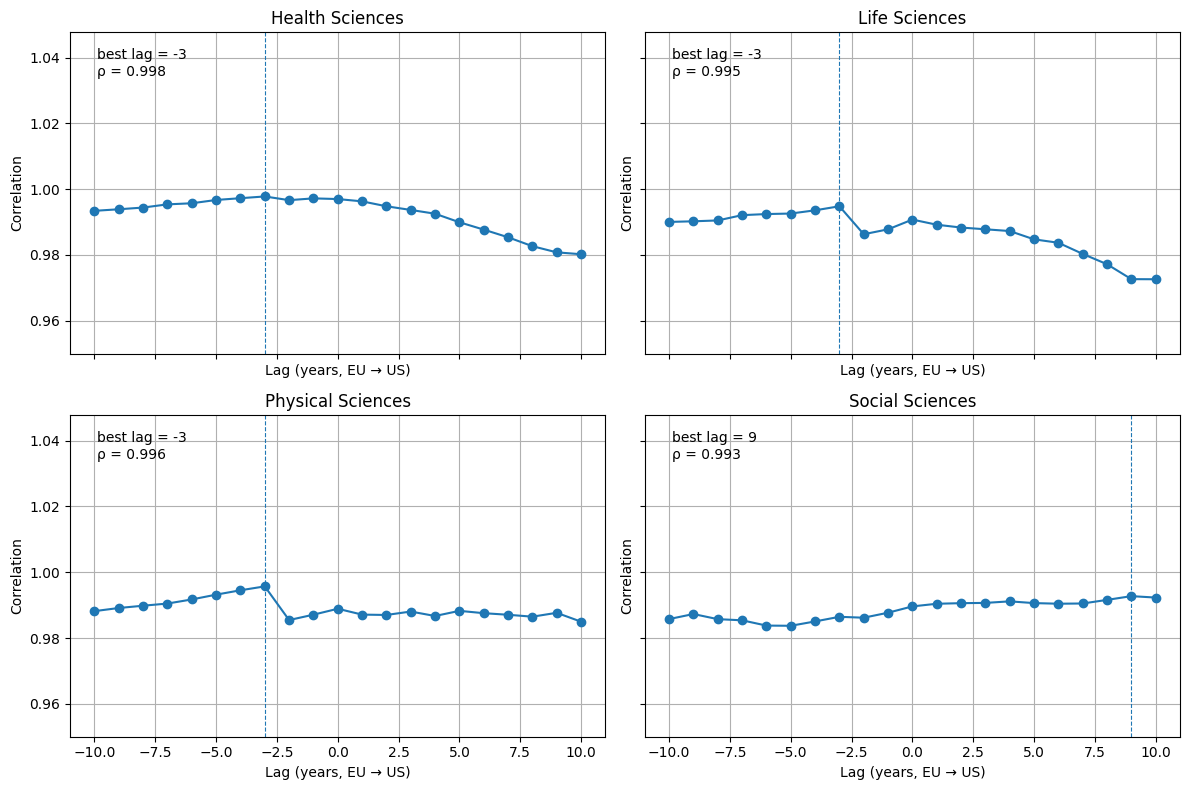

In [24]:
# Plotting and saving cross correlation results

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (field, res) in zip(axes, female_year_results.items()):
    cc = res["cross_correlation"]
    best_lag = res["best_lag"]
    best_corr = res["best_corr"]

    # Lag vs correlation as line + markers
    ax.plot(cc["lag"], cc["correlation"], marker="o")
    
    # Horizontal zero line
    ax.axhline(0, linestyle="--", linewidth=0.8)
    # Vertical line at best lag
    ax.axvline(best_lag, linestyle="--", linewidth=0.8)

    ax.set_title(field.replace("_", " ").title())
    ax.set_xlabel("Lag (years, EU → US)")
    ax.set_ylabel("Correlation")

    # Annotate best lag & correlation
    ax.text(
        0.05, 0.95,
        f"best lag = {best_lag}\nρ = {best_corr:.3f}",
        transform=ax.transAxes,
        va="top", ha="left",
    )
    ax.set_ylim(bottom=0.95)
    ax.grid(True)

plt.tight_layout()
#Save as png
plt.savefig("correlations_per_lack.png", dpi=600, bbox_inches="tight")
plt.show()


In [25]:
# Linear regression model
fields = ["health_sciences", "life_sciences",
          "physical_sciences", "social_sciences"]

results = {}

for field in fields:

    # US data
    df_us = globals()[f"gender_year_{field}_us"].copy()
    model_us = smf.ols("female_share ~ publication_year + alignment", data=df_us).fit() #linear model: y = betta_0 + betta_1 * publication_year + betta_2 * alignment

    # EU data
    df_eu = globals()[f"gender_year_{field}_eu"].copy()
    model_eu = smf.ols("female_share ~ publication_year + alignment", data=df_eu).fit() #linear model: y = betta_0 + betta_1 * publication_year + betta_2 * alignment

    results[field] = {
        "us": model_us,
        "eu": model_eu
    }


In [26]:
# Plotting and saving linear regression results

def save_summary_png(model, path, fontsize=10, pad_inches=0.02):
    """
    Render a statsmodels OLS summary() as a PNG with minimal white space.
    """

    text = model.summary().as_text()
    lines = text.splitlines()

    n_lines = len(lines)
    max_len = max(len(l) for l in lines)

    line_height_in = fontsize * 1.2 / 72
    char_width_in  = fontsize * 0.6 / 72  

    height_in = n_lines * line_height_in
    width_in  = max_len * char_width_in

    fig, ax = plt.subplots(figsize=(width_in, height_in))
    ax.axis("off")

    ax.text(
        0, 1, text,
        va="top",
        ha="left",
        family="monospace",
        fontsize=fontsize,
        transform=ax.transAxes,  # (0,0)-(1,1) coords
    )

    plt.savefig(path, dpi=600, bbox_inches="tight", pad_inches=pad_inches)
    plt.close(fig)


fields  = ["health_sciences", "life_sciences", "physical_sciences", "social_sciences"]
results[field]["us"]  # US model
results[field]["eu"]  # EU model

#Saving summaries
for field in fields:
    for region in ["us", "eu"]:
        model = results[field][region]

        filename = f"{field}_{region}_party_impact.png"
        save_summary_png(model, filename)
        print("saved:", filename)
    


saved: health_sciences_us_party_impact.png
saved: health_sciences_eu_party_impact.png
saved: life_sciences_us_party_impact.png
saved: life_sciences_eu_party_impact.png
saved: physical_sciences_us_party_impact.png
saved: physical_sciences_eu_party_impact.png
saved: social_sciences_us_party_impact.png
saved: social_sciences_eu_party_impact.png


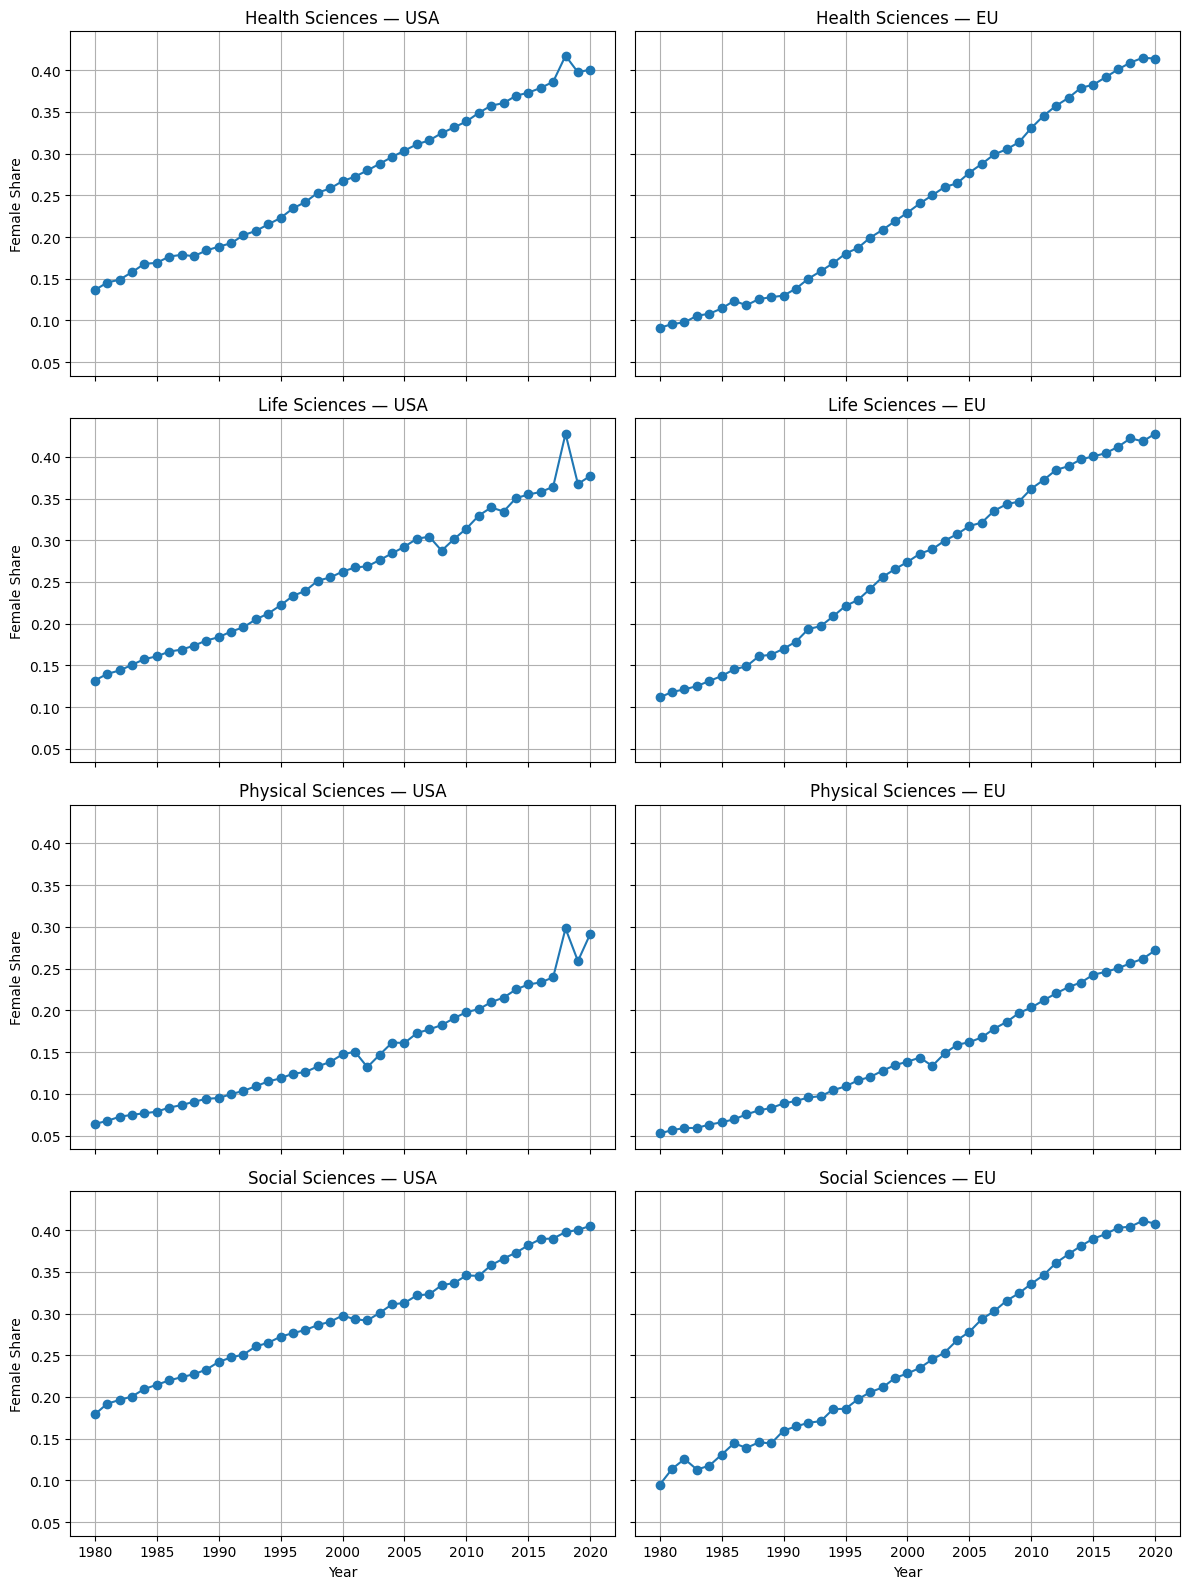

In [27]:
# Plotting female shares across all research domain in USA and EU

fields = ["health_sciences", "life_sciences", "physical_sciences", "social_sciences"]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16), sharex=True, sharey=True)

for i, field in enumerate(fields):

    df_us = globals()[f"gender_year_{field}_us"]
    df_eu = globals()[f"gender_year_{field}_eu"]

    # USA
    ax_us = axes[i, 0]
    ax_us.plot(df_us["publication_year"], df_us["female_share"], marker="o")
    ax_us.set_title(f"{field.replace('_', ' ').title()} — USA")
    ax_us.set_ylabel("Female Share")
    ax_us.grid(True)

    # EU
    ax_eu = axes[i, 1]
    ax_eu.plot(df_eu["publication_year"], df_eu["female_share"], marker="o")
    ax_eu.set_title(f"{field.replace('_', ' ').title()} — EU")
    ax_eu.grid(True)

for ax in axes[-1]:
    ax.set_xlabel("Year")

plt.tight_layout()

#Save as PNG
plt.savefig("female_share_plots.png", dpi=600, bbox_inches="tight")
plt.show()
